In [1]:
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.core.display import Markdown
from IPython.core.display_functions import display

import notebooks.config as config
import notebooks.utils as nb_utils
from src.features.multivariate_analysis import MACleaner
from src.features.utils import get_anova_importance_scores
from src.utils import Dataset, Metadata, preprocess_init

STAGE = 2
PREVIOUS_STAGE = STAGE - 1

%load_ext autoreload
%autoreload 2

## Load cleaned data and metadata from artifacts

In [2]:
def load_dataset_and_metadata() -> Tuple[Dataset, Metadata]:
    df, metadata = (
        nb_utils.load_artifacts(
            nb_utils.STAGES_DICT[PREVIOUS_STAGE]["name"],
            nb_utils.STAGES_DICT[PREVIOUS_STAGE]["folder_path"],
        )
    )
    return df, metadata

In [3]:
df, metadata = load_dataset_and_metadata()

## Multivariate Analysis

### Irregular label rows

In [4]:
@preprocess_init
def ma_irregular_label_rows_nb(
    df: Dataset, metadata: Metadata
) -> Tuple[Dataset, Metadata]:
    idx_to_remove = metadata.idx_to_remove

    print("Cars that contain 'ucesc' or 'učešć' in the 'name' column")
    no_price_cond = df["name"].str.contains("ucesc|učešć", case=False)
    display(
        df.loc[no_price_cond, ["name", "short_url", "ai_installment_amount", "price"]]
    )
    print()

    display(
        Markdown("It can be seen that some cars had value of price, but some didn't.")
    )
    print()

    print("Cars where 'price' = 'ai_installment_amount'")
    df_cars_equal_price_install_amt = df.loc[
        df[config.LABEL] == df.ai_installment_amount, :
    ]
    display(df_cars_equal_price_install_amt)
    print()

    df.drop(df_cars_equal_price_install_amt.index, axis=0, inplace=True)
    print("Removed cars where 'price' = 'ai_installment_amount'")

    idx_to_remove.extend(df_cars_equal_price_install_amt.index.tolist())

    return df, metadata

In [5]:
df, metadata = ma_irregular_label_rows_nb(df=df, metadata=metadata)

Cars that contain 'ucesc' or 'učešć' in the 'name' column


,name,short_url,ai_installment_amount,price
id,,,,
22681846,Renault Scenic RATA 114e BEZ UČEŠĆA,https://www.polovniautomobili.com/auto-oglasi/...,114,114
22681838,BMW X1 RATA 222e BEZ UČEŠĆA,https://www.polovniautomobili.com/auto-oglasi/...,222,222
22903371,BMW 420 RATA 426e BEZ UČEŠĆA,https://www.polovniautomobili.com/auto-oglasi/...,426,19499
22903376,Škoda Superb RATA 171e BEZ UČEŠĆA,https://www.polovniautomobili.com/auto-oglasi/...,171,171
23172948,Nissan Qashqai KREDlTl BEZ UCESCA,https://www.polovniautomobili.com/auto-oglasi/...,150,8450
22969571,BMW 318 RATA 130e BEZ UCESCA,https://www.polovniautomobili.com/auto-oglasi/...,130,130
23099826,Audi A4 RATA 171e BEZ UCESCA,https://www.polovniautomobili.com/auto-oglasi/...,171,171
22681938,Volkswagen Golf 5 RATA 107e BEZ UČEŠĆA,https://www.polovniautomobili.com/auto-oglasi/...,107,107
22681931,Fiat EVO RATA 107e BEZ UČEŠĆA,https://www.polovniautomobili.com/auto-oglasi/...,107,107


It can be seen that some cars had value of price, but some didn't.


Cars where 'price' = 'ai_installment_amount'


,name,short_url,price,listing_followers_no,location,images_no,description,gi_brand,gi_model,gi_production_year,...,o_Garažiran,o_Kupljen_nov_u_Srbiji,o_Oldtimer,o_Prilagođeno_invalidima,o_Prvi_vlasnik,o_Restauriran,o_Rezervni_ključ,o_Servisna_knjiga,o_Test_vozilo,o_Tuning
id,,,,,,,,,,,,,,,,,,,,,
22681846,Renault Scenic RATA 114e BEZ UČEŠĆA,https://www.polovniautomobili.com/auto-oglasi/...,114,8,Beograd,23,................................DOBRODOSLI U A...,Renault,Scenic,2010,...,False,False,False,False,False,False,False,False,False,False
22681838,BMW X1 RATA 222e BEZ UČEŠĆA,https://www.polovniautomobili.com/auto-oglasi/...,222,22,Beograd,44,................................DOBRODOSLI U A...,BMW,X1,2011,...,False,False,False,False,False,False,False,False,False,False
22903376,Škoda Superb RATA 171e BEZ UČEŠĆA,https://www.polovniautomobili.com/auto-oglasi/...,171,7,Beograd,29,................................DOBRODOSLI U A...,Škoda,Superb,2010,...,False,False,False,False,False,False,False,False,False,False
22969571,BMW 318 RATA 130e BEZ UCESCA,https://www.polovniautomobili.com/auto-oglasi/...,130,2,Beograd,8,VOZILO U DOLASKU,BMW,318,2011,...,False,False,False,False,False,False,False,False,False,False
23099826,Audi A4 RATA 171e BEZ UCESCA,https://www.polovniautomobili.com/auto-oglasi/...,171,5,Beograd,33,...................DOBRODOSLI U AUTO PLAC VULI...,Audi,A4,2008,...,True,False,False,False,True,False,False,False,False,False
22681938,Volkswagen Golf 5 RATA 107e BEZ UČEŠĆA,https://www.polovniautomobili.com/auto-oglasi/...,107,26,Beograd,30,................................DOBRODOSLI U A...,Volkswagen,Golf 5,2006,...,False,False,False,False,False,False,False,False,False,False
22681931,Fiat EVO RATA 107e BEZ UČEŠĆA,https://www.polovniautomobili.com/auto-oglasi/...,107,15,Beograd,32,................................DOBRODOSLI U A...,Fiat,EVO,2011,...,False,False,False,False,False,False,False,False,False,False
21787916,Fiat Grande Punto 104e RATA BEZ UCESCA,https://www.polovniautomobili.com/auto-oglasi/...,104,54,Beograd,27,................................DOBRODOSLI U A...,Fiat,Grande Punto,2011,...,False,False,False,False,False,False,False,False,False,False
22898494,Škoda Superb RATA 314e BEZ UCESCA,https://www.polovniautomobili.com/auto-oglasi/...,314,28,Beograd,48,................................DOBRODOSLI U A...,Škoda,Superb,2017,...,False,False,False,False,False,False,False,False,False,False



Removed cars where 'price' = 'ai_installment_amount'


### Clean low kilometerage cars

In [6]:
@preprocess_init
def ma_low_kilometerage_cars_nb(
    df: Dataset, metadata: Metadata
) -> Tuple[Dataset, Metadata]:
    idx_to_remove = metadata.idx_to_remove

    low_kilometerage_amount = 500
    print(f"Cars where 'gi_kilometerage' < {low_kilometerage_amount}")
    low_kilometerage_cars = df.loc[
        df["gi_kilometerage"] < low_kilometerage_amount,
        ["name", "short_url", "price", "gi_kilometerage"],
    ]
    display(low_kilometerage_cars)
    print()

    df.drop(low_kilometerage_cars.index, axis=0, inplace=True)
    print(f"Dropped cars where 'gi_kilometerage' < {low_kilometerage_amount}")

    idx_to_remove.extend(low_kilometerage_cars.index.tolist())

    return df, metadata

In [7]:
df, metadata = ma_low_kilometerage_cars_nb(df=df, metadata=metadata)

Cars where 'gi_kilometerage' < 500


,name,short_url,price,gi_kilometerage
id,,,,
18764867,BMW X3 2.0xDrive LCI,https://www.polovniautomobili.com/auto-oglasi/...,68350,2
22918835,Toyota Aygo X,https://www.polovniautomobili.com/auto-oglasi/...,15290,130
22479960,Dacia Duster 1.5 dci n1 expresion,https://www.polovniautomobili.com/auto-oglasi/...,22000,3
22327387,Opel Crossland X ///nov///,https://www.polovniautomobili.com/auto-oglasi/...,18999,25
23213165,Fiat 500 1.0 Dolcevita Hybrid,https://www.polovniautomobili.com/auto-oglasi/...,15499,6
21693713,Renault Megane Equilibre 115dci,https://www.polovniautomobili.com/auto-oglasi/...,21950,11
23200938,Great Wall POER,https://www.polovniautomobili.com/auto-oglasi/...,28800,5
21996306,BMW 520 d xDrive 2023,https://www.polovniautomobili.com/auto-oglasi/...,78990,2
21996178,BMW 520 xDrive 2024,https://www.polovniautomobili.com/auto-oglasi/...,77990,2



Dropped cars where 'gi_kilometerage' < 500


### High seats cars

In [8]:
@preprocess_init
def ma_high_seats_cars_nb(df: Dataset, metadata: Metadata) -> Tuple[Dataset, Metadata]:
    idx_to_remove = metadata.idx_to_remove

    high_seats_no = 5
    high_seats = df.loc[df.ai_seats_no > high_seats_no, ["name", "ai_seats_no"]]

    print("Frequencies of 'ai_seats_no' of extreme high number of seats cars")
    display(high_seats.ai_seats_no.value_counts())
    print()

    extreme_high_seats_no = 7
    print(f"Cars where 'ai_seats_no' > {extreme_high_seats_no}")
    more_than_7_seats = high_seats[high_seats.ai_seats_no > extreme_high_seats_no]
    display(more_than_7_seats)
    print()

    df.drop(more_than_7_seats.index, axis=0, inplace=True)
    print(f"Dropped cars where 'ai_seats_no' > {extreme_high_seats_no}")

    idx_to_remove.extend(more_than_7_seats.index.tolist())

    return df, metadata

In [9]:
df, metadata = ma_high_seats_cars_nb(df=df, metadata=metadata)

Frequencies of 'ai_seats_no' of extreme high number of seats cars


ai_seats_no
7    735
6     42
8     13
9      7
Name: count, dtype: Int64


Cars where 'ai_seats_no' > 7


,name,ai_seats_no
id,,
22681822,Toyota Land Cruiser,8
15786162,Toyota Land Cruiser,8
12665476,Lincoln Town car STRETCHLIMO,8
22503186,Toyota Land Cruiser PRADO,8
23222567,Mercedes Benz V Klasa E.XTRA LONG,8
23178101,Opel 1.5 D,9
20229898,Ford Tourneo Connect 8 SEDISTA,8
22914575,Fiat Scudo MAXI/LONG/9sed,9
23228117,Volkswagen Multivan,9



Dropped cars where 'ai_seats_no' > 7


### Oldtimers

In [10]:
@preprocess_init
def ma_oldtimers_nb(df: Dataset, metadata: Metadata) -> Tuple[Dataset, Metadata]:
    idx_to_remove = metadata.idx_to_remove

    oldtimers = df.loc[
        df.o_Oldtimer,
        [
            "name",
            "gi_production_year",
            "price",
            "short_url",
            "gi_kilometerage",
            "gi_engine_capacity",
            "gi_engine_power",
            "ai_seats_no",
            "o_Restauriran",
        ],
    ]

    oldtimers_pairplot = sns.pairplot(data=oldtimers.drop(columns=["o_Restauriran"]))
    plt.close()
    print("Oldtimers pairplot")
    display(oldtimers_pairplot.figure)
    print()

    seats_no = 2
    print(f"Oldtimer cars with 'ai_seats_no' = {seats_no}")
    oldtimer_2_seats = oldtimers[oldtimers.ai_seats_no == seats_no]
    display(oldtimer_2_seats)
    print()

    df.drop(oldtimer_2_seats.index, inplace=True)
    print(f"Dropped oldtimer cars with 'ai_seats_no' = {seats_no}")
    print()

    idx_to_remove.extend(oldtimer_2_seats.index.tolist())

    oldtimers.drop(oldtimer_2_seats.index, inplace=True)

    ot_production_year = 2000
    print(f"Oldtimers produced before year {ot_production_year}")
    nb_utils.show_hist_box_numerical_col(
        oldtimers[oldtimers.gi_production_year < ot_production_year],
        "gi_production_year",
    )

    return df, metadata

Oldtimers pairplot


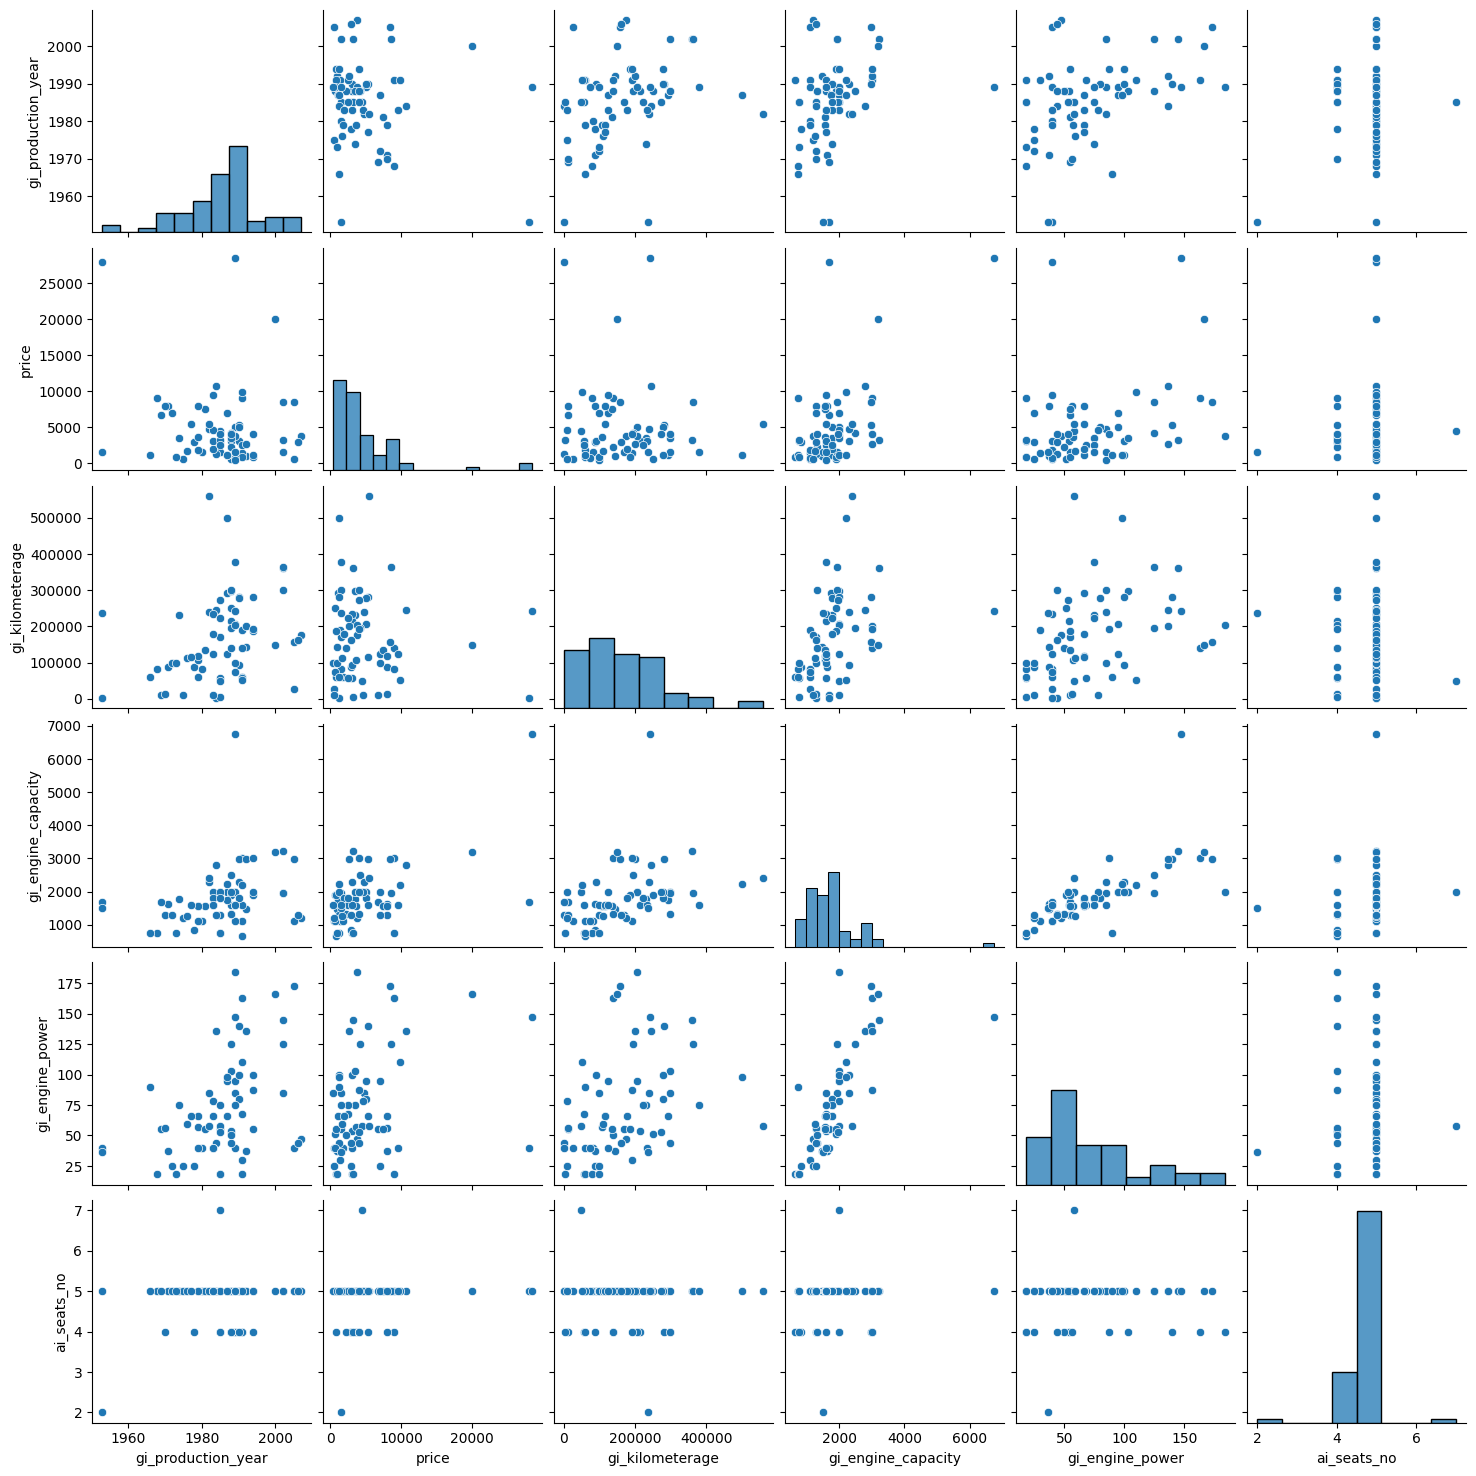


Oldtimer cars with 'ai_seats_no' = 2


,name,gi_production_year,price,short_url,gi_kilometerage,gi_engine_capacity,gi_engine_power,ai_seats_no,o_Restauriran
id,,,,,,,,,
23205081,Jeep Willys,1953,1600,https://www.polovniautomobili.com/auto-oglasi/...,235687,1500,36,2,False



Dropped oldtimer cars with 'ai_seats_no' = 2

Oldtimers produced before year 2000
Univariate analysis of 'gi_production_year' column
Histogram and box plot


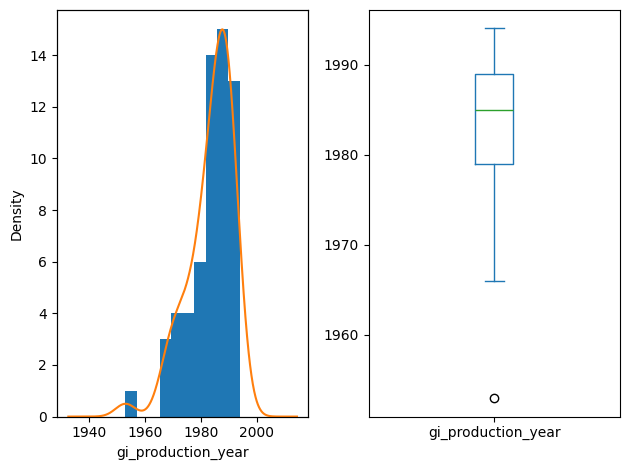

Descriptive statistics


count           60.0
mean     1983.466667
std         8.110396
min           1953.0
25%           1979.0
50%           1985.0
75%           1989.0
max           1994.0
Name: gi_production_year, dtype: Float64

Variance: 0.0040890006456657845
Skewness: -1.2992677851046495
Kurtosis: 1.9400654848883008

NA values
Count [n]: 0
Percentage [%]: 0.0%


In [11]:
df, metadata = ma_oldtimers_nb(df=df, metadata=metadata)

### Renovated cars

In [12]:
@preprocess_init
def ma_renovated_cars_nb(df: Dataset, metadata: Metadata) -> Tuple[Dataset, Metadata]:
    renovated_cars = df.loc[
        df.o_Restauriran,
        [
            "name",
            "gi_production_year",
            "price",
            "short_url",
            "gi_kilometerage",
            "gi_engine_capacity",
            "gi_engine_power",
            "ai_seats_no",
            "o_Restauriran",
            "o_Oldtimer",
        ],
    ]

    renovated_pairplot = sns.pairplot(data=renovated_cars.drop(columns="o_Oldtimer"))
    plt.close()
    print("Renovated cars pairplot")
    display(renovated_pairplot.figure)
    print()

    fig, ax = plt.subplots(1, 2)

    sns.kdeplot(df, x="price", hue="o_Restauriran", common_norm=False, ax=ax[0])
    sns.histplot(
        df,
        x="price",
        stat="probability",
        hue="o_Restauriran",
        common_norm=False,
        ax=ax[1],
    )
    plt.close()

    print(f"'{config.LABEL}' by 'o_Restauriran'")
    display(fig)
    print()

    display(
        Markdown(
            "Nothing can be extracted from these plots because the sample size for true is too small."
        )
    )
    print()

    print("Show countplot of renovated cars by 'o_Oldtimer' feature")
    sns.countplot(renovated_cars, x="o_Oldtimer", hue="o_Restauriran", legend=False)

    return df, metadata

Renovated cars pairplot


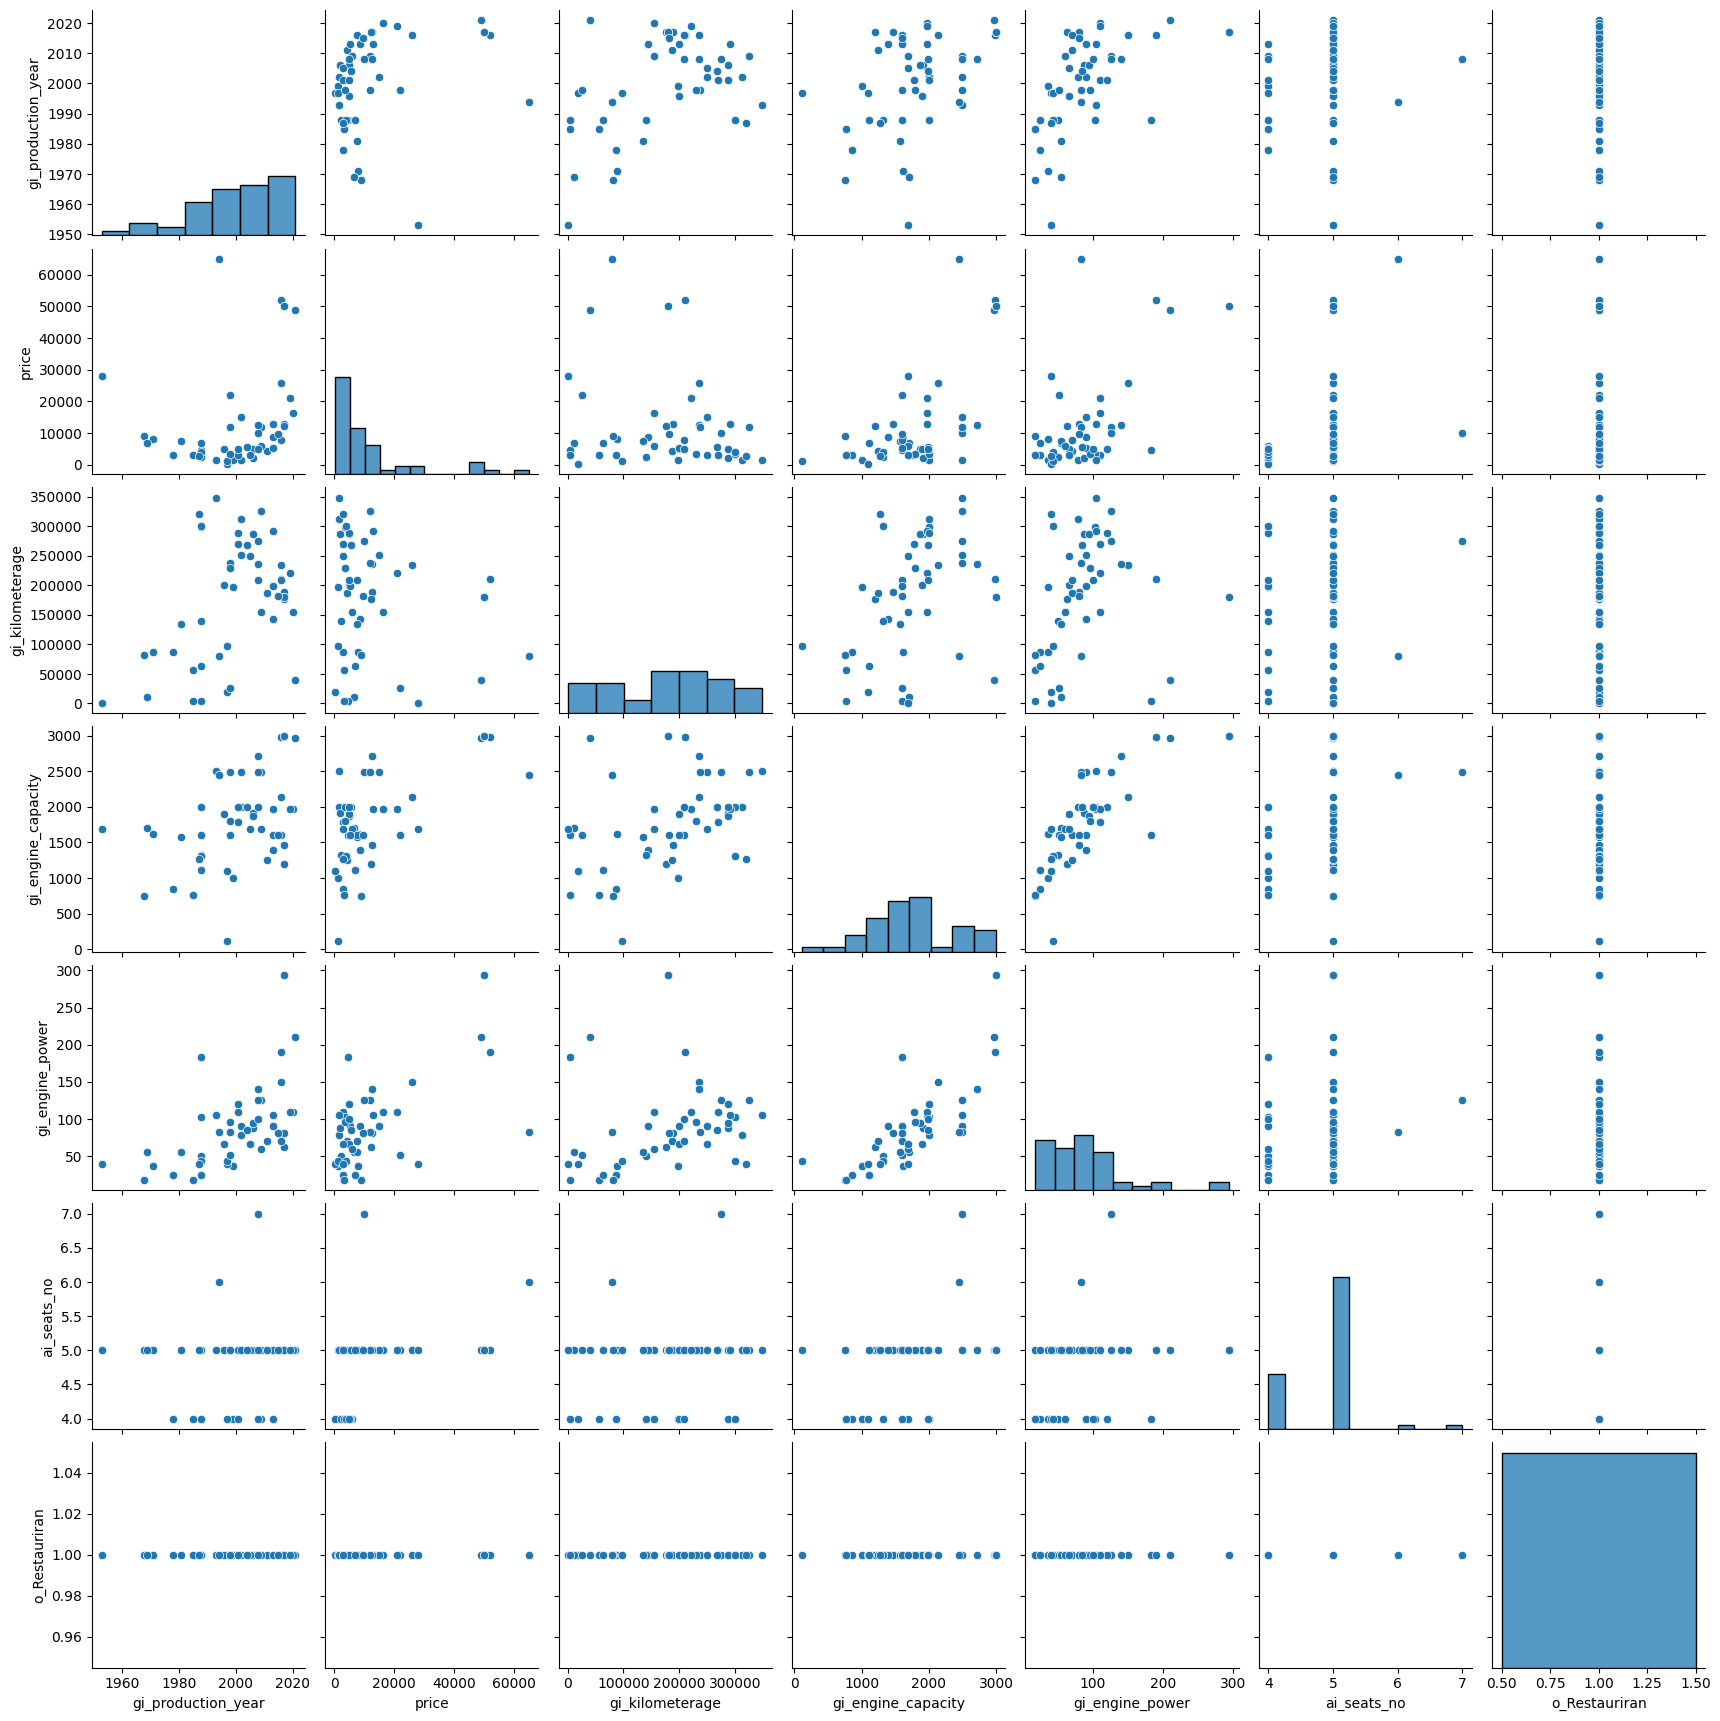


'price' by 'o_Restauriran'


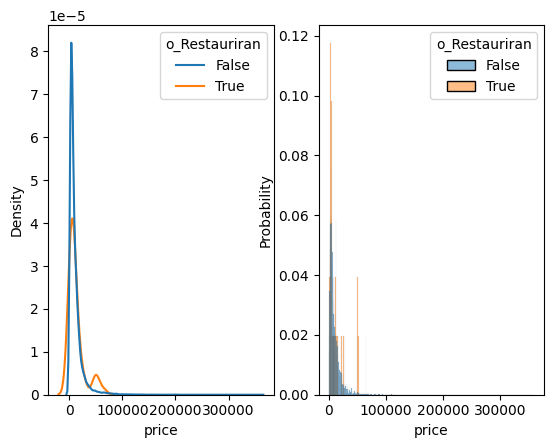

Nothing can be extracted from these plots because the sample size for true is too small.


Show countplot of renovated cars by 'o_Oldtimer' feature


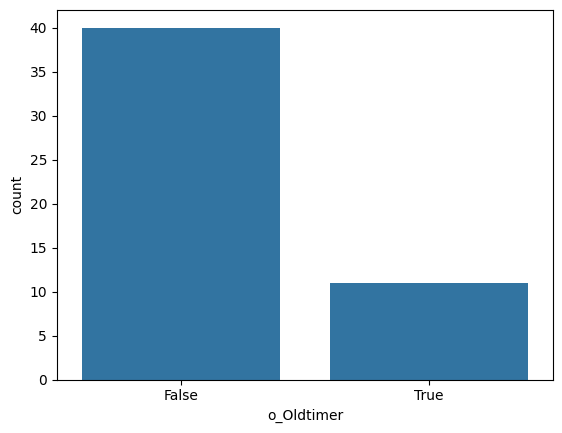

In [13]:
df, metadata = ma_renovated_cars_nb(df=df, metadata=metadata)

### Correlations

#### Numerical columns

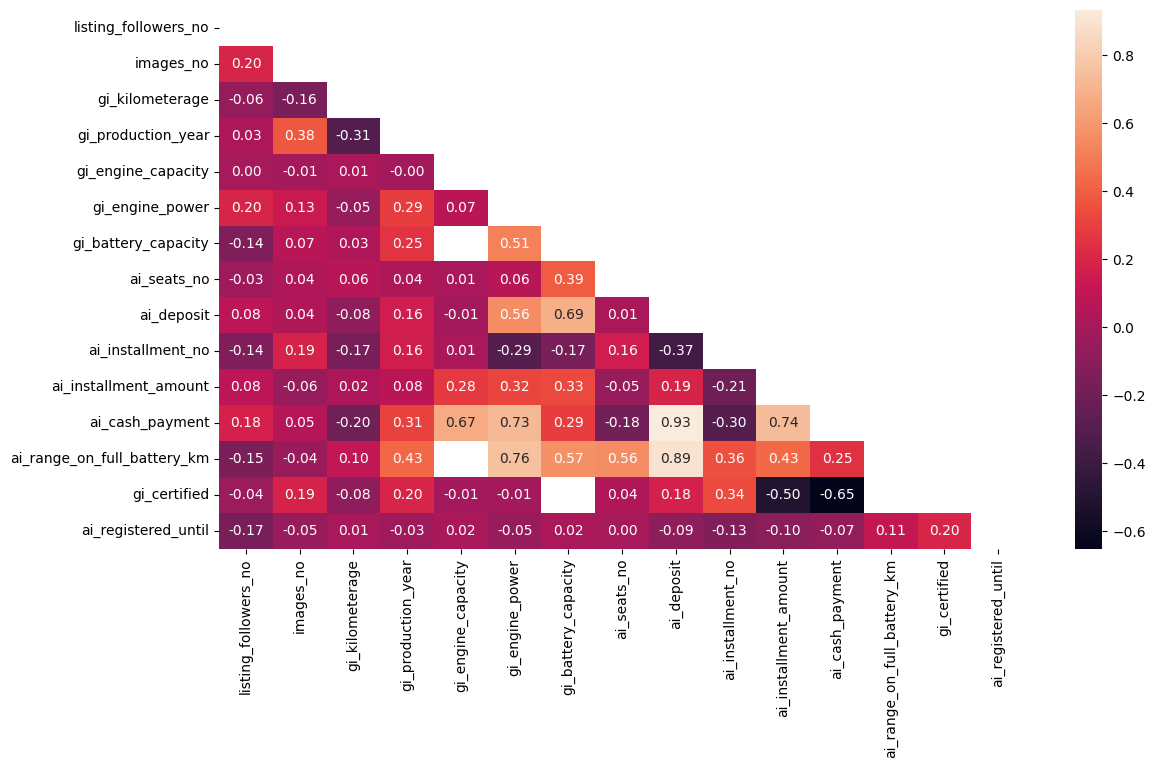

In [14]:
corr_numerical = df[metadata.features_info["numerical"]].corr()
nb_utils.plot_correlation_heatmap(corr=corr_numerical);

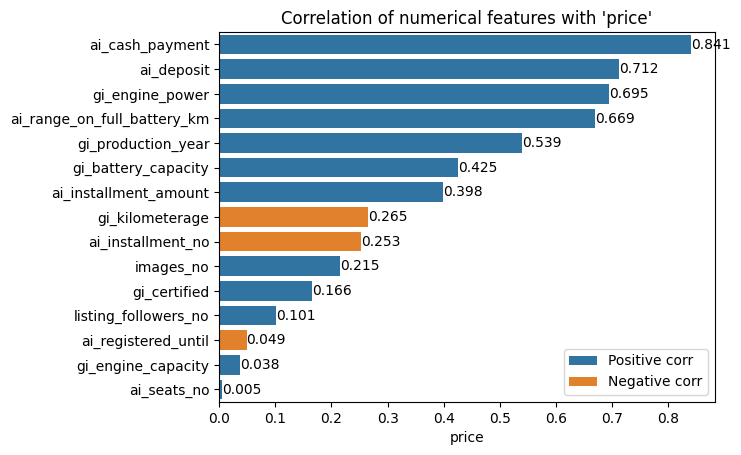

In [15]:
corr_numerical_and_label = df[metadata.features_info["numerical"] + [config.LABEL]].corr()
corr_numerical_with_label = (
    corr_numerical_and_label[config.LABEL]
    .drop(config.LABEL)
    .sort_values(key=lambda x: abs(x), ascending=False)
)

colors = [
    "Positive corr" if val > 0 else "Negative corr" for val in corr_numerical_with_label
]
nb_utils.plot_bar_correlations(
    corr=corr_numerical_with_label.round(3), colors=colors, by=config.LABEL
);

### Feature importance

#### Safety columns

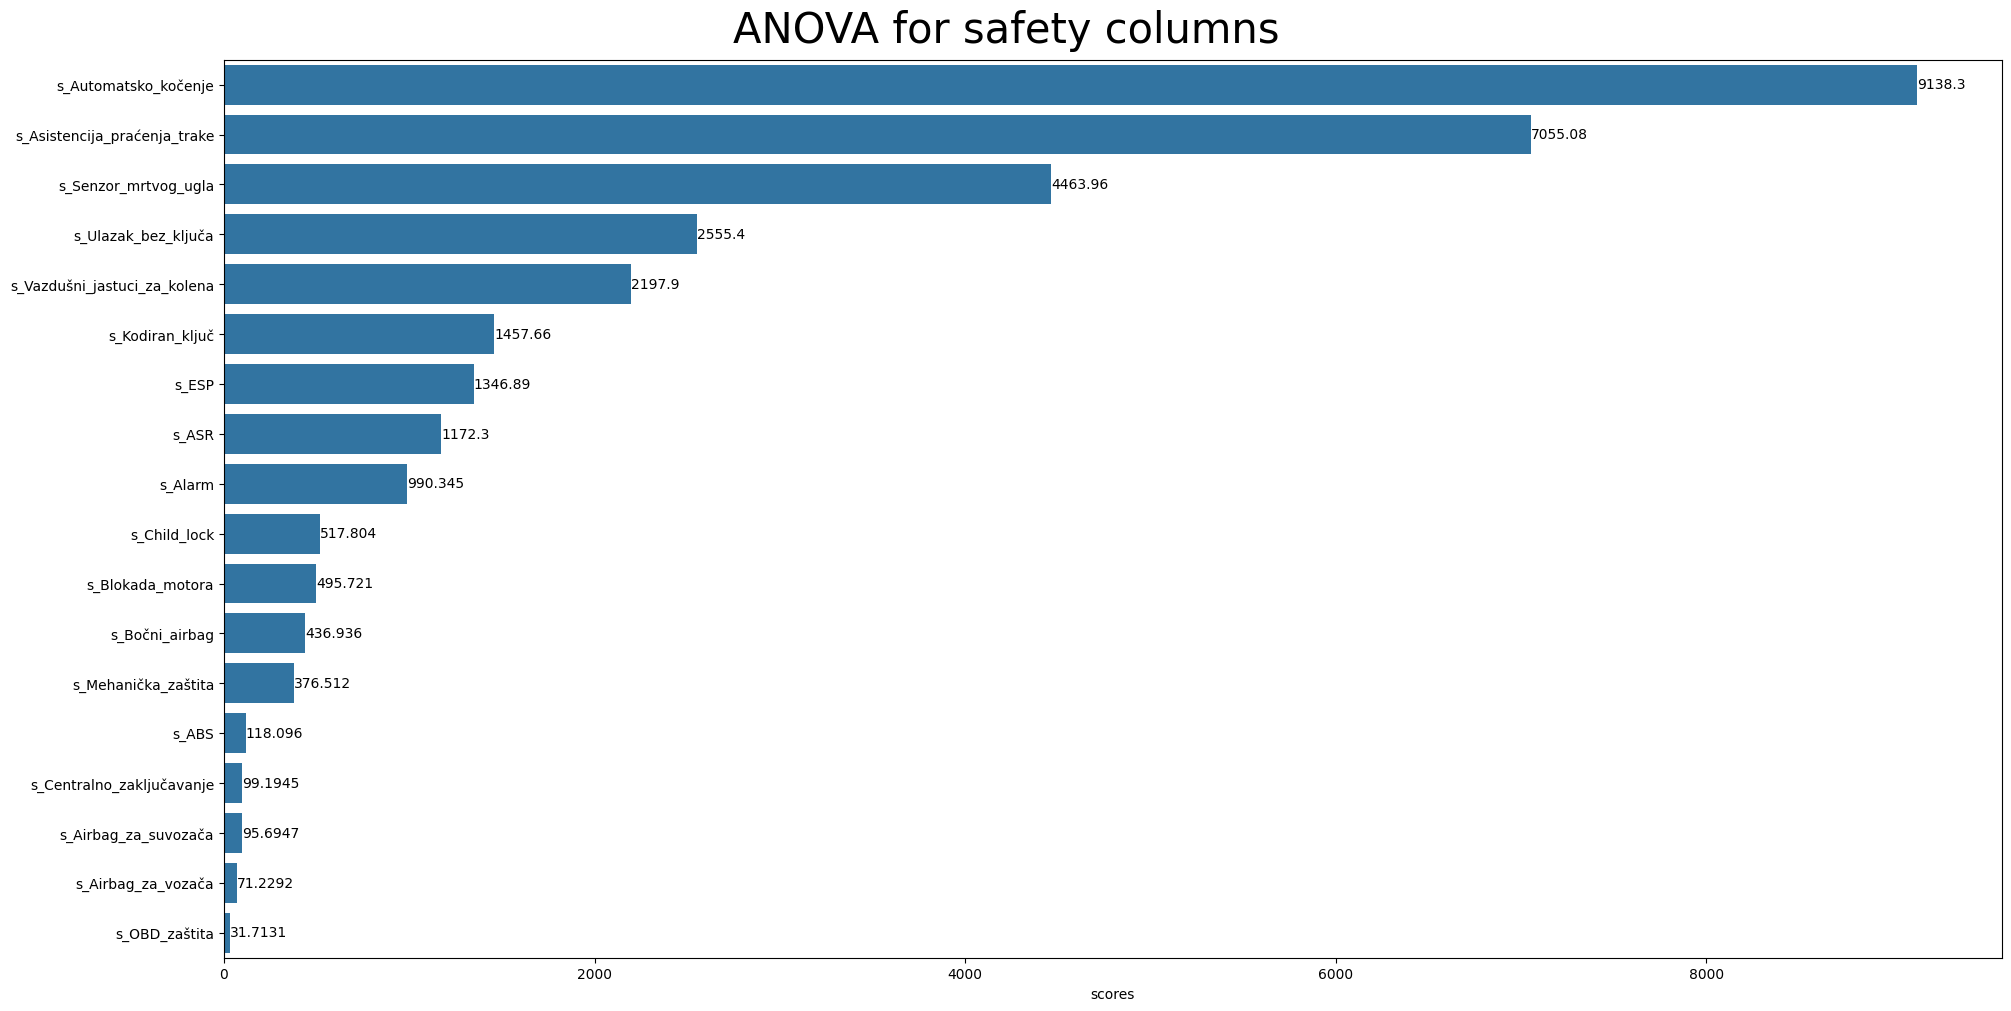

In [16]:
safety_columns = [
    col for col in metadata.features_info["binary"] if col.startswith("s_")
]

anova_scores = get_anova_importance_scores(X=df[safety_columns], y=df[config.LABEL])
nb_utils.plot_anova_importance(anova_scores, "ANOVA for safety columns");

#### Equipment columns

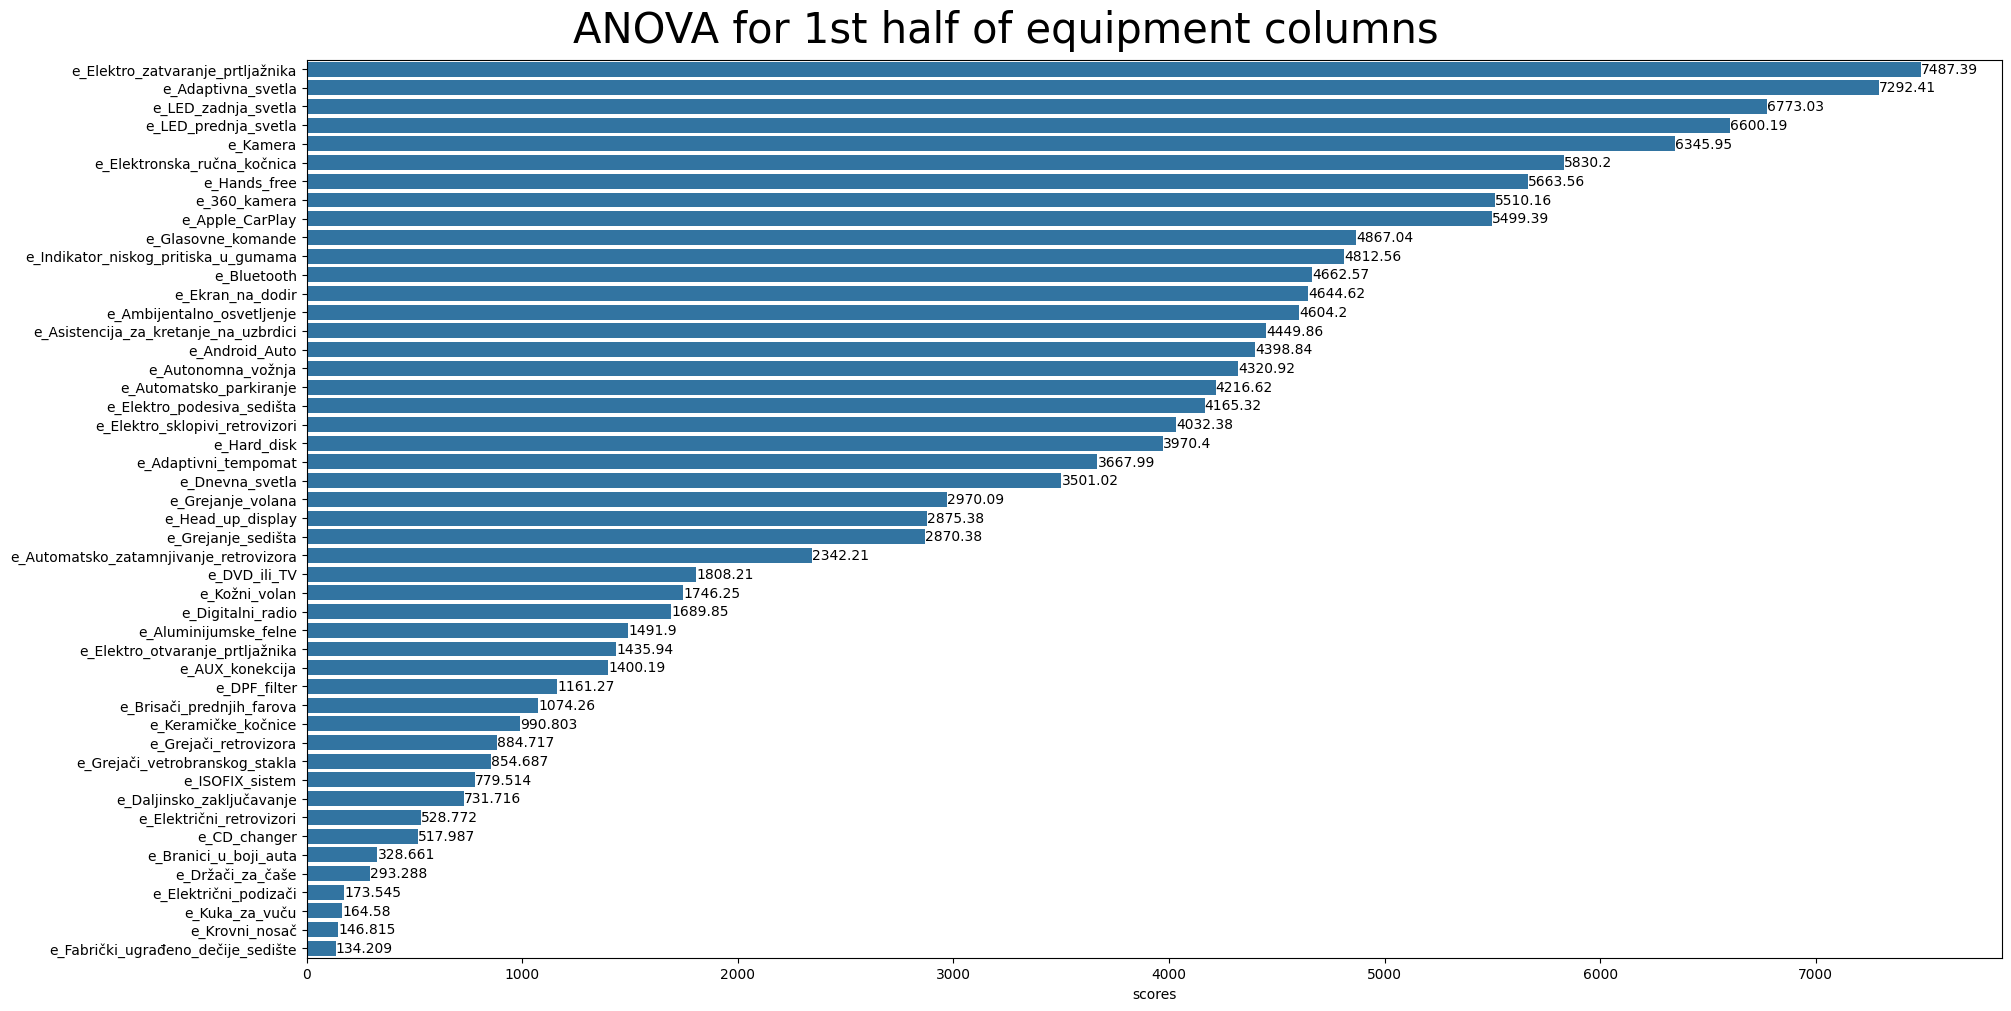

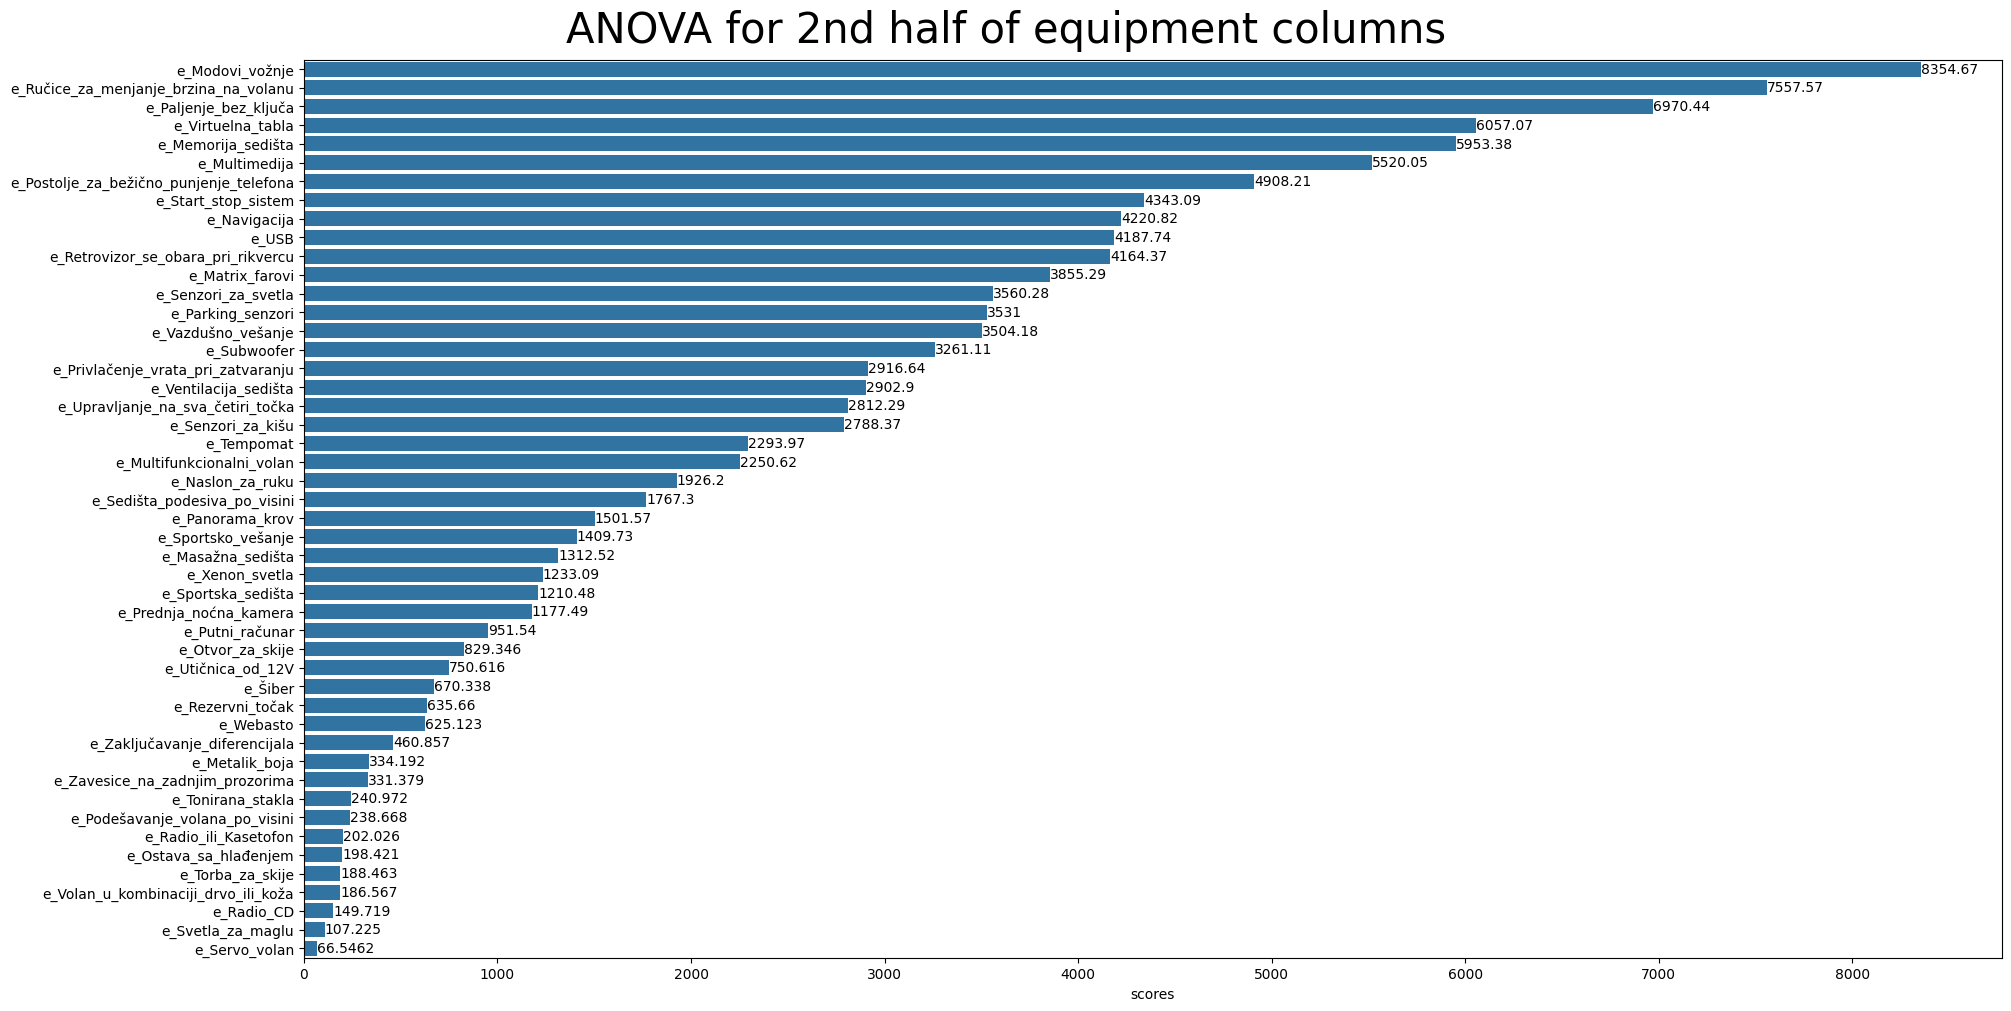

In [17]:
equipment_columns = [
    col for col in metadata.features_info["binary"] if col.startswith("e_")
]

equipment_columns_1_half = equipment_columns[: len(equipment_columns) // 2]
equipment_columns_2_half = equipment_columns[len(equipment_columns) // 2 + 1 :]

fig, (ax_1, ax_2) = plt.subplots(1, 2)

anova_scores_1 = get_anova_importance_scores(
    X=df[equipment_columns_1_half], y=df[config.LABEL]
)
anova_scores_2 = get_anova_importance_scores(
    X=df[equipment_columns_2_half], y=df[config.LABEL]
)

ax_1 = nb_utils.plot_anova_importance(
    anova_scores_1, "ANOVA for 1st half of equipment columns"
)
ax_2 = nb_utils.plot_anova_importance(
    anova_scores_2, "ANOVA for 2nd half of equipment columns"
)
plt.close()

#### Other columns

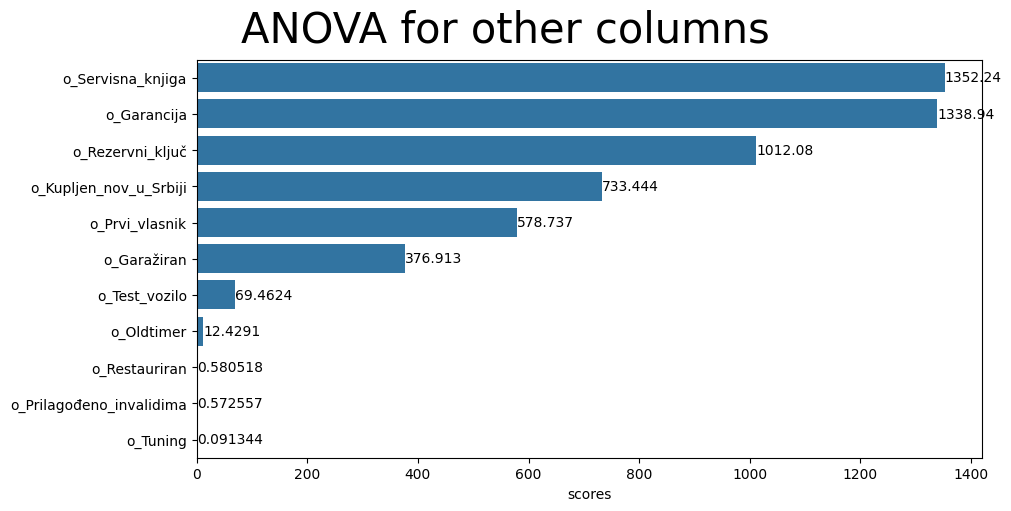

In [18]:
other_columns = [
    col for col in metadata.features_info["binary"] if col.startswith("o_")
]

anova_scores = get_anova_importance_scores(X=df[other_columns], y=df[config.LABEL])
nb_utils.plot_anova_importance(anova_scores, "ANOVA for other columns", figsize=(10, 5));

### Finalize processing

Since 'gi_battery_capacity' column has +0.425 correlation with 'price', that means it can benefit to the model, but the important thing we need to have in mind is that over 100 cars had values for 'gi_battery_capacity' feature.
<br><br>
Similar for 'ai_range_on_full_battery_km', where correlation is +0.669.
<br><br>
'ai_seats_no' shows almost 0 correlation, which is kind of weird. We would except cars that have more seats to be at least somewhat more expensive.

In [19]:
@preprocess_init
def ma_finalize_nb(df: Dataset, metadata: Metadata) -> Tuple[Dataset, Metadata]:
    features_info = metadata.features_info
    cols_nan_strategy = metadata.cols_nan_strategy

    features_info["features_to_delete"].remove("gi_battery_capacity")
    features_info["features_to_delete"].remove("ai_range_on_full_battery_km")

    cols_nan_strategy["const_0"].extend(
        ["gi_battery_capacity", "ai_range_on_full_battery_km"]
    )

    return df, metadata

In [20]:
df, metadata = ma_finalize_nb(df=df, metadata=metadata)

## Testing

### Test individual components

In [21]:
class TestNotebook:
    # Testing only df_train
    def test_ma_generic(self, function_name: str):
        df_ua, metadata_ua = load_dataset_and_metadata()
        df_nb, metadata_nb = load_dataset_and_metadata()

        func_name_ua = f"ma_{function_name}"
        func_name_nb = f"{func_name_ua}_nb"

        mac_obj = MACleaner(metadata_ua)

        # Get function from class object from .py file
        func_ua = getattr(mac_obj, func_name_ua)
        # Get function defined in this notebook
        func_nb = globals()[func_name_nb]

        df_ua, metadata_ua = func_ua(df=df_ua, metadata=metadata_ua)
        df_nb, metadata_nb = func_nb(df=df_nb, metadata=metadata_nb)

        pd.testing.assert_frame_equal(df_ua, df_nb)
        assert metadata_ua == metadata_nb

        # Test features info for duplicates
        nb_utils.test_features_info_duplicates(metadata_nb.features_info)
        nb_utils.test_features_info_duplicates(metadata_ua.features_info)

        # Test columns nan strategy for duplicates
        nb_utils.test_cols_nan_strategy_duplicates(metadata_nb.cols_nan_strategy)
        nb_utils.test_cols_nan_strategy_duplicates(metadata_ua.cols_nan_strategy)

    def start(self):
        self.test_ma_generic("irregular_label_rows")
        self.test_ma_generic("low_kilometerage_cars")
        self.test_ma_generic("high_seats_cars")
        self.test_ma_generic("oldtimers")

In [ ]:
test_obj = TestNotebook()
test_obj.start()

### Test whole component

In [23]:
@preprocess_init
def test_whole_component(df: Dataset, metadata: Metadata):
    df_init, metadata_init = load_dataset_and_metadata()

    macleaner_obj = MACleaner(metadata_init)

    df_ma = macleaner_obj.clean(df=df_init)
    metadata_ma = macleaner_obj.metadata

    pd.testing.assert_frame_equal(df, df_ma)
    assert metadata == metadata_ma

    # Test features info for duplicates
    nb_utils.test_features_info_duplicates(metadata.features_info)
    nb_utils.test_features_info_duplicates(metadata_ma.features_info)

    # Test features info with columns
    nb_utils.test_features_info_with_columns(df, metadata.features_info)
    nb_utils.test_features_info_with_columns(df_ma, metadata_ma.features_info)

    # Test columns nan strategy for duplicates
    nb_utils.test_cols_nan_strategy_duplicates(metadata.cols_nan_strategy)
    nb_utils.test_cols_nan_strategy_duplicates(metadata_ma.cols_nan_strategy)

    # Test columns nan strategy with features info
    nb_utils.test_cols_nan_strategy_with_features_info(
        metadata.cols_nan_strategy, metadata.features_info
    )
    nb_utils.test_cols_nan_strategy_with_features_info(
        metadata_ma.cols_nan_strategy, metadata_ma.features_info
    )

In [24]:
test_whole_component(df=df, metadata=metadata)

## Save cleaned data and metadata in artifacts

In [25]:
nb_utils.save_artifacts(
    nb_utils.STAGES_DICT[STAGE]["name"],
    nb_utils.STAGES_DICT[STAGE]["folder_path"],
    df,
    metadata,
)